In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import onlinelossmax as olm
sys.path.insert(0, './src')
from scipy import stats
import rff, subsample, herding
%matplotlib inline

In [2]:
class SyntheticTarget(object):
    
    def __init__(self, dist_components=2, dim=2, seed=None):
        if seed is not None:
            np.random.seed(seed)
        self.dist_weights = stats.dirichlet(np.ones(dist_components)*10).rvs().ravel()
        dist_centers = np.random.uniform(-4, 4, size=(dist_components, dim))

        def gen_cov():
            assert(dim == 2)
            rho = np.random.rand()-0.5
            sd = np.random.rand(dim)*0.4+0.5
            L = np.zeros((dim,dim))
            L[0,0] = sd[0]**2
            L[1,1] = sd[1]**2
            L[0,1] = rho*sd.prod()
            return np.dot(L, L.T)

        dist_cov = np.array([gen_cov() for i in xrange(dist_components)])
        self.dist_obj = np.array([stats.multivariate_normal(dist_centers[k], dist_cov[k]) for k in xrange(dist_components)], dtype=object)
        self.dim = dim

    def compute_pdf(self, x):
        return np.sum(self.dist_weights[:,None,None] * np.array([d.pdf(x) for d in self.dist_obj]), 0)

    def draw_sample(self, ns=1):
        component = np.random.multinomial(ns, self.dist_weights) # np.argmin(np.random.rand() > self.dist_weights.cumsum())
        offset = np.concatenate(([0], component.cumsum()[:-1]))
        samples = np.empty((ns,self.dim))
        for c, n in enumerate(component):
            if n > 0:
                samples[offset[c]:offset[c]+n] = self.dist_obj[c].rvs(n) 
        np.random.shuffle(samples)
        return samples

    def draw_sample_slow(self):
        component = np.argmin(np.random.rand() > self.dist_weights.cumsum())
        return self.dist_obj[component].rvs()

    def plot(self):
        delta = 0.1
        boundary = 5
        x = np.arange(-boundary, boundary, delta)
        y = np.arange(-boundary, boundary, delta)
        X, Y = np.meshgrid(x, y)
        Z = np.log(self.compute_pdf(np.concatenate((X[:,:,None],Y[:,:,None]),2)))
        plt.figure()
        contour_levels = np.arange(-9,1)
        CS = plt.contour(X, Y, Z, levels=contour_levels)
        plt.set_cmap('Blues')

In [3]:
# Change for different sampled target dist
SEED = 666
ex = SyntheticTarget(seed=SEED, dist_components=2)
N = 10000
M = 10
stream = ex.draw_sample(N)
#stream.shape finds the dimensions of the nparray stream
print stream.shape, "=>", M

(10000, 2) => 10


In [4]:
#The below generates the function to calculate phi_hat, median_heuristic calcuates a value for gamma.
phi = rff.RFF(500, 2, lengthscale=rff.median_heuristic(stream[:M])) 
initial_prototypes = np.array(stream[:M])
intial_criticisms = np.array(stream[M:2*M])

# Compute batch benchmark feature mean
#full_stream_phi = phi(stream).mean(0)
#full_stream_sq_norm = np.sum(full_stream_phi**2,0)

subsampler = subsample.LinearSubsampler(initial_prototypes, phi, logging=True)
subsampler.which

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
for i in xrange(2*M, len(stream)):
    if np.mod(i, 5000) == 1:
        print i-1
    subsampler.consider(stream[i])
    
prototype_indices = subsampler.which

5000


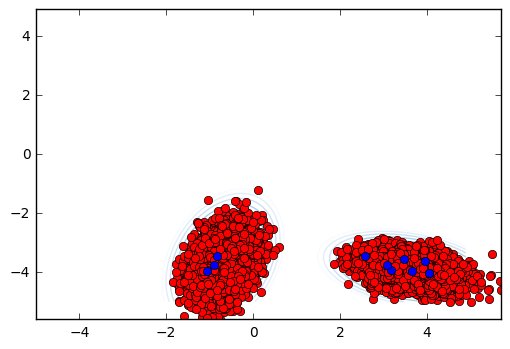

In [6]:
ex.plot()
plt.plot(stream[:N,0], stream[:N,1], 'ro');
#The below generates the function to calculate phi_hat, median_heuristic calcuates a value for gamma.
phi = rff.RFF(500, 2, lengthscale=rff.median_heuristic(stream[:M])) 
initial_prototypes = np.array(stream[:M])
intial_criticisms = np.array(stream[M:2*M])

# Compute batch benchmark feature mean
#full_stream_phi = phi(stream).mean(0)
#full_stream_sq_norm = np.sum(full_stream_phi**2,0)

subsampler = subsample.LinearSubsampler(initial_prototypes, phi, logging=True)
plt.plot(stream[prototype_indices,0], stream[prototype_indices,1], 'bo');

In [30]:
from __future__ import division  #So that when we divide by integers we gegt a float. Eg so that 5/2 = 2.5 not 2.
import numpy as np


def online_loss_max(new_phi, phis_for_criticisms, full_phi_sum, proto_phi_sum, prototype_indices, criticism_indices, n, M, full_stream_phi, N):
    #ONLINE_LOSS_MAX maximizes L(C) online.
    #Here we are adding x_n and assume that stored_phis and full_phi_sum have been updated to include x_new: the new data point.
    
    criticism_indices = np.hstack((criticism_indices,n-1))
    phis_for_criticisms = np.vstack((phis_for_criticisms,new_phi))
    #print phis_for_criticisms.shape
    
    losses = np.zeros(M+1)
    overall_losses = np.zeros(M+1)
    for l in range(M+1):
        losses[l] = np.abs((1/n)*np.inner(full_phi_sum, phis_for_criticisms[l,:]) - (1/M)*np.inner(proto_phi_sum, phis_for_criticisms[l,:]))
        overall_losses[l] = np.abs((1/N)*np.inner(full_stream_phi, phis_for_criticisms[l,:]) - (1/M)*np.inner(proto_phi_sum, phis_for_criticisms[l,:]))
    
    #print(sum(overall_losses))
    
    #print(losses)
    min_loss_idx = np.argmin(losses)
    min_loss = losses[min_loss_idx]
    new_loss = losses[M]
    #print(min_loss_idx)
    #print(sum(losses))

    if new_loss > min_loss:
        #print(criticism_indices)
        criticism_indices = np.delete(criticism_indices, min_loss_idx)
        phis_for_criticisms = np.delete(phis_for_criticisms, (min_loss_idx), axis=0)
        #print phis_for_criticisms.shape
        
    else:
        criticism_indices = np.delete(criticism_indices, M)
        phis_for_criticisms = np.delete(phis_for_criticisms, (M), axis=0)
        #print phis_for_criticisms.shape
        
    olm_return = [criticism_indices, phis_for_criticisms]
    return olm_return

In [33]:
#The below generates the function to calculate phi_hat, median_heuristic calcuates a value for gamma.
phi = rff.RFF(500, 2, lengthscale=rff.median_heuristic(stream[:M])) 

#Initialization:
prototype_points = np.array(stream[:M])
criticism_indices = range(M, 2*M)
phis_for_criticisms = phi(np.array(stream[criticism_indices]))

# Compute batch benchmark feature mean
#full_stream_phi = phi(stream).mean(0)
#full_stream_sq_norm = np.sum(full_stream_phi**2,0)

subsampler = subsample.LinearSubsampler(prototype_points, phi, logging=True)
full_stream_phi = sum(phi(stream))

#for i in xrange(2*M, len(stream)):
for i in range(2*M, N):
    if np.mod(i, 5000) == 1:
        print i-1
    subsampler.consider(stream[i])
    prototype_indices = subsampler.which
    is_accepted = subsampler.accepted[-1]
    
    if not is_accepted:
        olm_return = online_loss_max(new_phi = phi(stream[i]), phis_for_criticisms = phis_for_criticisms, 
                                         full_phi_sum = (i+1)*subsampler._full_mean_phi, 
                                         proto_phi_sum = M*subsampler._subset_mean_phi, 
                                         prototype_indices = prototype_indices, 
                                         criticism_indices = criticism_indices, n = i+1, 
                                         M = M, full_stream_phi = full_stream_phi, N = N)
        criticism_indices = olm_return[0]
        #print criticism_indices
        #print criticism_indices
        phis_for_criticisms = olm_return[1]
        
print criticism_indices
print prototype_indices
        
    


5000
[10 11 12 13 14 15 16 17 18 19]
[9522 7032 6813 9004 5225 9472 4667 8719 5306 6767]


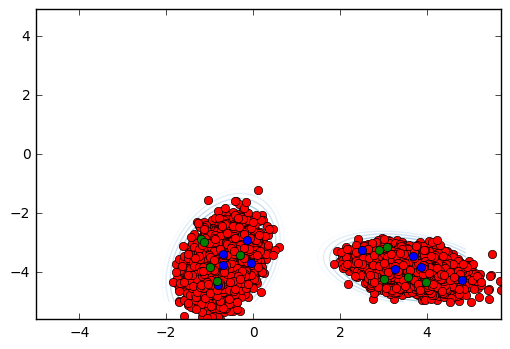

In [34]:
data = stream
ex.plot()
plt.plot(data[:N,0], data[:N,1], 'ro');
plt.plot(data[prototype_indices,0], data[prototype_indices,1], 'bo');
plt.plot(data[criticism_indices,0], data[criticism_indices,1], 'go');

In [22]:
stream[1]

array([ 2.82979896, -3.47356867])

In [36]:
test_phi = phi(np.array([ -10, 10]))

In [37]:
np.abs((1/N)*np.inner(full_stream_phi, test_phi) - (1/M)*np.inner(M*subsampler._subset_mean_phi, test_phi))

array([ 0.00026571])

In [38]:
M*subsampler._subset_mean_phi

array([  5.92584224e-01,  -9.56277483e-02,   1.35576358e-01,
        -5.32821618e-01,   3.63542435e-02,   1.88663816e-01,
        -4.66574874e-01,  -2.24383169e-01,   3.69676924e-01,
        -4.76735342e-01,   3.25313781e-01,  -1.04431143e-01,
        -5.54426640e-01,   1.95770521e-01,   9.61951970e-02,
        -1.67465459e-01,  -1.68405449e-04,  -3.98995862e-02,
         6.03178808e-01,  -2.10827042e-01,   4.35080934e-01,
        -1.43378265e-01,   4.95475200e-01,   1.77978390e-01,
        -1.53738449e-01,  -3.14510524e-01,  -3.62286513e-01,
        -3.24778156e-02,   2.32576783e-01,  -1.28776429e-01,
         2.40525912e-01,   8.55591339e-02,   1.10269338e-01,
         2.57955140e-02,  -3.80512890e-02,   1.65208525e-01,
        -4.71636079e-02,  -1.68529398e-01,  -2.68473293e-01,
         7.60667325e-02,  -5.64245498e-03,  -5.14499964e-01,
         1.92068140e-01,   2.49306829e-01,   1.31860290e-01,
        -1.61094113e-01,   6.98581134e-02,  -2.02020389e-01,
        -2.34517865e-01,

In [58]:
np.sum(phi(stream[prototype_indices]), axis = 0)

array([ 0.59611318, -0.1559007 ,  0.19958506, -0.51538518, -0.00968334,
        0.1359988 , -0.4901799 , -0.25727608,  0.38707952, -0.45499357,
        0.32980211, -0.08888952, -0.56331882,  0.1456268 ,  0.11415815,
       -0.18671955, -0.20050884, -0.01914535,  0.60295934, -0.25464028,
        0.31586285, -0.09804693,  0.50793504,  0.25546802, -0.0040679 ,
       -0.29681086, -0.36751054, -0.07130776,  0.25658615, -0.14662778,
        0.25570177,  0.11749532,  0.18340158,  0.04525442, -0.00385563,
        0.1760905 , -0.08834161, -0.04201433, -0.2871302 , -0.0074228 ,
       -0.0700599 , -0.5355486 ,  0.20915948,  0.27375891,  0.09319276,
       -0.16646867,  0.00636214, -0.17425091, -0.2011148 , -0.06466618,
        0.27486174, -0.30911767, -0.04522394,  0.28566812,  0.3711151 ,
        0.1954177 ,  0.05894172, -0.11571224,  0.05275916, -0.25517989,
       -0.01377838, -0.31736423, -0.41885213,  0.48398562,  0.30993989,
        0.22714787,  0.47488592,  0.61701361,  0.45563412,  0.19

In [46]:
test_phi = phi(np.array([ -100000000, 10000000]))

In [47]:
np.abs((1/N)*np.inner(sum(phi(stream)), test_phi) - (1/M)*np.inner(sum(phi(stream[prototype_indices])), test_phi))

array([ 0.00542724])

In [49]:
test_phi = phi(np.array([ -1, -3]))

In [50]:
np.abs((1/N)*np.inner(sum(phi(stream)), test_phi) - (1/M)*np.inner(sum(phi(stream[prototype_indices])), test_phi))

array([ 0.02026332])

In [53]:
np.inner(np.array(range(1,3)), np.array(range(1,3)))

5

In [52]:
range(1,2)

[1]

In [57]:
print phi(stream[prototype_indices]).shape

(10, 500)
